In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import datasets, transforms
from tqdm import tqdm

from src.VAE import LinearVAE, MultiLinearVAE

In [2]:
encoder1 = nn.Sequential(nn.Linear(28 * 28, 256),
                         nn.ReLU(),
                         nn.Linear(256, 128),
                         nn.ReLU())
decoder1 = nn.Sequential(nn.Linear(64, 128),
                         nn.ReLU(),
                         nn.Linear(128, 256),
                         nn.ReLU(),
                         nn.Linear(256, 28 * 28),
                         nn.Sigmoid())
vae = LinearVAE(encoder1, decoder1, 128, 64)

In [2]:
def KLD(mu: torch.Tensor, log_var: torch.Tensor):
    return -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())


def BCE(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.binary_cross_entropy(recon, X, reduction='mean')


def L1Loss(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.l1_loss(recon, X, reduction='mean')


def L2Loss(recon: torch.Tensor, X: torch.Tensor):
    return nn.functional.mse_loss(recon, X, reduction='mean')

In [7]:
transform = transforms.Compose([
    transforms.ToTensor()
])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                          transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                          transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=1024, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=10000)

## Only BCE

In [63]:
model = vae.to('cuda')
optimizer = optim.Adadelta(model.parameters(), lr=1e1)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=False, threshold=1e-3)

In [64]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    allLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, _ in tEpoch:
            data = data.to('cuda').view(-1, 28 * 28)
            optimizer.zero_grad()
            output, mu, log_var = model(data)
            loss = BCE(output, data)
            loss.backward()
            optimizer.step()
            allLoss.append(loss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tLoss: {:.6f}\t lr: {:.8f}'.format(
                epoch, loss.item(), optimizer.param_groups[0]['lr']))
    return allLoss


def test(model, train_loader, epoch):
    model.eval()
    allLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, _ in tEpoch:
            data = data.to('cuda').view(-1, 28 * 28)
            output, mu, log_var = model(data)
            loss = BCE(output, data)
            allLoss.append(loss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tTest loss: {:.6f}'.format(
                epoch, loss.item()))
    return allLoss

In [65]:
for epoch in range(1, 201):
    _ = train(model, train_loader, optimizer, epoch)
    loss = test(model, test_loader, epoch)
    scheduler.step(np.mean(loss))

 68%|██████▊   | 40/59 [00:03<00:01, 13.09batch/s,  Epoch: 88 	Loss: 0.081446	 lr: 0.00000100]


KeyboardInterrupt: 

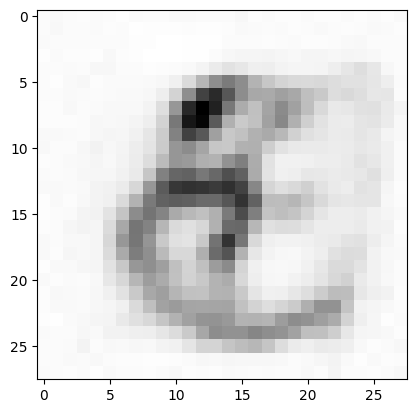

In [75]:
z = torch.normal(0, 1, size=(1, 64)).cuda()
plt.imshow(model.sample(z).cpu().detach().view(28, 28), cmap='Greys')

In [79]:
img0 = next(iter(test_loader))[0][0]

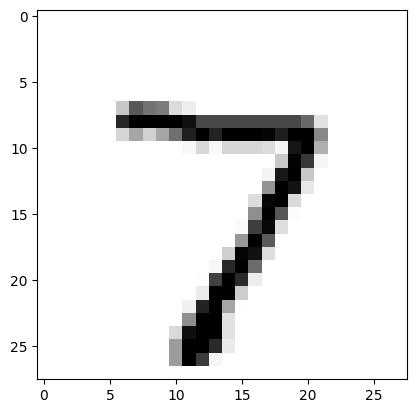

In [80]:
plt.imshow(img0[0], cmap='Greys')

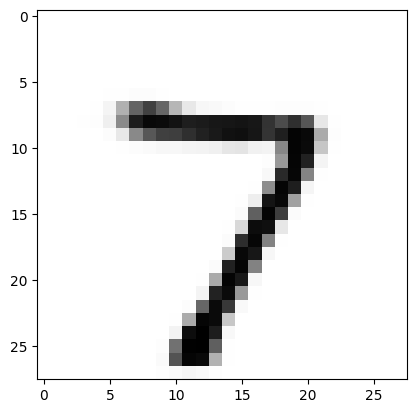

In [81]:
output, _, _ = model(img0.view(-1, 28 * 28).cuda())
plt.imshow(output.cpu().detach().view(28, 28), cmap='Greys')

## Cast label into same latent space

In [41]:
encoder2 = nn.Sequential(nn.Linear(28 * 28 + 10, 256),
                         nn.ReLU(),
                         nn.Linear(256, 128),
                         nn.ReLU())
decoder2 = nn.ModuleList([nn.Sequential(nn.Linear(64, 128),
                                        nn.ReLU(),
                                        nn.Linear(128, 256),
                                        nn.ReLU(),
                                        nn.Linear(256, 28 * 28),
                                        nn.Sigmoid()),
                          nn.Sequential(nn.Linear(64, 32),
                                        nn.ReLU(),
                                        nn.Linear(32, 10))])
model = MultiLinearVAE(encoder2, decoder2, 128, 64).cuda()
optimizer = optim.Adadelta(model.parameters(), lr=1e1)
scheduler = ReduceLROnPlateau(optimizer, factor=0.1, patience=5, verbose=False, threshold=1e-3)

In [42]:
def train(model, train_loader, optimizer, epoch):
    model.train()
    allLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, label in tEpoch:
            data = data.view(-1, 28 * 28)
            label = nn.functional.one_hot(label).to(torch.float32)
            optimizer.zero_grad()
            output, mu, log_var = model(torch.cat((data, label), -1).cuda())
            reconLoss = BCE(output[0], data.cuda())
            loss = reconLoss + nn.functional.cross_entropy(output[1], label.cuda())
            # loss = reconLoss
            loss.backward()
            optimizer.step()
            allLoss.append(reconLoss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tLoss: {:.6f}\tRecon Loss :{:.6f} \t lr: {:.8f}'.format(
                epoch, loss.item(), reconLoss, optimizer.param_groups[0]['lr']))
    return allLoss


def test(model, train_loader, epoch):
    model.eval()
    allLoss = []
    with tqdm(train_loader, unit='batch') as tEpoch:
        for data, label in tEpoch:
            data = data.view(-1, 28 * 28)
            label = nn.functional.one_hot(label).to(torch.float32)
            output, mu, log_var = model(torch.cat((data, label), -1).cuda())
            reconLoss = BCE(output[0], data.cuda())
            loss = reconLoss + nn.functional.cross_entropy(output[1], label.cuda())
            allLoss.append(reconLoss.item())
            tEpoch.set_postfix_str(' Epoch: {} \tTest Loss: {:.6f}\tRecon Loss :{:.6f}'.format(
                epoch, loss.item(), reconLoss))
    return allLoss

In [43]:
for epoch in range(1, 201):
    _ = train(model, train_loader, optimizer, epoch)
    loss = test(model, test_loader, epoch)
    scheduler.step(np.mean(loss))

 17%|█▋        | 10/59 [00:01<00:05,  9.38batch/s,  Epoch: 185 	Loss: 0.125524	Recon Loss :0.125524 	 lr: 0.10000000]


KeyboardInterrupt: 

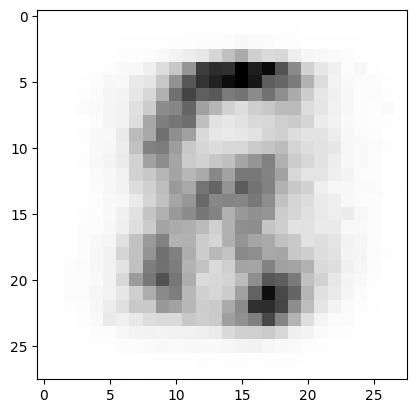

In [48]:
z = torch.normal(0, 1, size=(1, 64)).cuda()
plt.imshow(model.sample(z)[0].cpu().detach().view(28, 28), cmap='Greys')

In [52]:
img0 = next(iter(test_loader))[0][0]
label0 = next(iter(test_loader))[1][0]

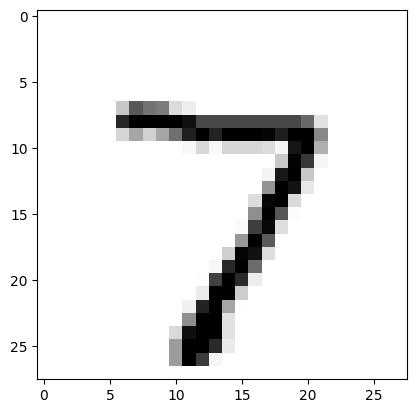

In [53]:
plt.imshow(img0[0], cmap='Greys')

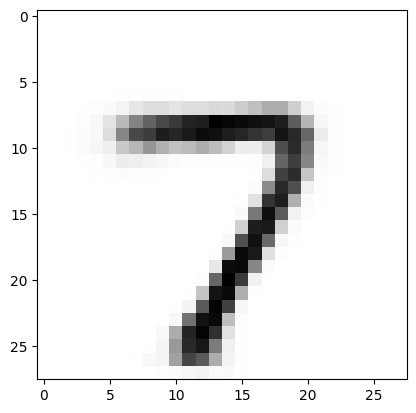

In [61]:
input1=torch.cat((img0.view(-1, 28 * 28),nn.functional.one_hot(label0,10).unsqueeze(0)),dim=-1)
output, _, _ = model(input1.cuda())
plt.imshow(output[0].cpu().detach().view(28, 28), cmap='Greys')

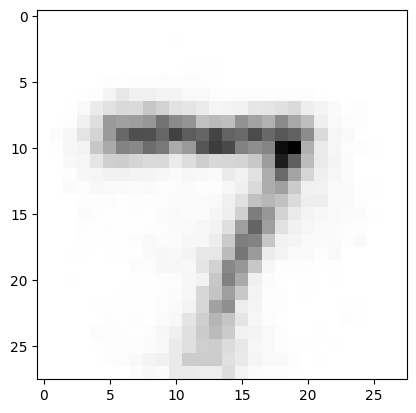

In [133]:
input0=torch.cat((torch.zeros(size=(1,28*28)),nn.functional.one_hot(label0,10).unsqueeze(0)),dim=-1)
output, _, _ = model(input0.cuda())
plt.imshow(output[0].cpu().detach().view(28, 28), cmap='Greys')

In [88]:
input2=torch.cat((img0.view(-1, 28 * 28),torch.zeros(size=(1,10))),dim=-1)
output, _, _ = model(input0.cuda())
print(output[1])

tensor([[-35.8496, -13.5304, -10.1696,  18.1317, -18.0739,   1.3481, -36.4790,
          32.8876,  -7.4857,  10.3978]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


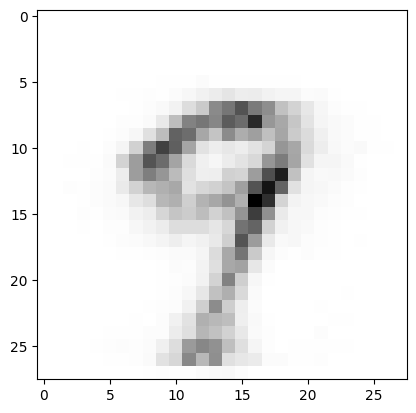

In [157]:
input0=torch.cat((torch.zeros(size=(1,28*28)),nn.functional.one_hot(torch.tensor(9),10).unsqueeze(0)),dim=-1)
output, _, _ = model(input0.cuda())
plt.imshow(output[0].cpu().detach().view(28, 28), cmap='Greys')